In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

In [ ]:
# list(df_train.columns)

In [ ]:
# train_transaction.head() # KEEP

In [ ]:
# train_identity.head() # KEEP

In [ ]:
# train_transaction.info(); # KEEP

In [ ]:
# train_identity.info(); # KEEP

#### Data Quality Check

In [ ]:
# list_null = df_train.isnull().any()
# df_null = pd.DataFrame(list_null).reset_index()
# df_null

In [ ]:
# df_train.loc[:,df_train.isnull().any()]['id_34'].unique()

In [ ]:
# KEEP
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

In [ ]:
# df_train.isnull().any() # KEEP

In [ ]:
# df_train.info() # KEEP

In [ ]:
# df_train.dtypes # KEEP

#### EDA

In [338]:
# # How many transactions are in the dataset?
# df_train.shape # KEEP

In [339]:
# # What is the fraud rate of the data set?
# fraud_rate = df_train.isFraud.value_counts() / 590540
# fraud_rate  # KEEP

In [340]:
# What is the statistical overview of the data set?
# df_train.describe() # KEEP

In [341]:
# fraud_summary = df_train.groupby('isFraud')
# fraud_summary.mean()

In [48]:
# fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_groupby.csv')

In [350]:
# df_train.isnull().any()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info
# TEST: test imputing with missing instead of mode to see if we have improvements in model 

In [ ]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [ ]:
# ['addr1', 'addr2', 'ProductCD', 'P_emaildomain', 'card1', 'card2', 'card3', 'card4', 
#  'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M6']
'DeviceType','DeviceInfo', 'P_emaildomain','R_emaildomain', 'TransactionID', 
'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD'

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

In [293]:
##########################################

In [22]:
print(list(df_eda.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [185]:
# look at the distribution of our top 5 email providers, and put all others in "other" columns
# Was fraud more likely to occur on one day or so than another?
# What were the top TransactionAmt that were fraud? 
# What were the top TransactionAmt that were not fraud?
# Is fraud more likely to occur on debit or credit? 
# Does fraud happen in one address more than another? Look at the values counts for addr1 and isFraud
# 
# whats a more insightful feature? How can we combine addr1 and addr2 to better predict fraud? Are two 
# certain pairs more likely to produce better fraud prediction accuracy?? 
# Look at card type, look at the distribution. Look at the distribution of isFraud=0 and isFraud=1
# Can we compare transaction amount for each card type and for each fraud type
# can we compare the transaction amount, 
# what are important insights in our data? 
# transaction amount, card type, transaction date, time between transactions...
# df_raw[['D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15']].describe()
# Lets look at transactionAmt by card4

# who are our top 5 email providers? Who are our top 5 email providers with fraud transactions?

# we need to find something insightful about the data... look at debit, credit, etc. card6

# Note: We cannot do stacked bar charts because we have a 97:3 ratio. We can't perform EDA on columns with lots of 
# missing data

In [5]:
df_eda = df_raw.copy() # create df_eda
# df_eda = df_eda[0:1000]
mode_card4 = df_eda.card4.mode()[0]
df_eda['card4'] = df_eda.card4.fillna(mode_card4)

mode_card6 = df_eda.card6.mode()[0]
df_eda['card6'] = df_eda.card6.fillna(mode_card6)

df_eda_not_fraud = df_eda[df_eda.isFraud==0]
df_eda_fraud = df_eda[df_eda.isFraud==1]



In [239]:
print(list(df_eda_not_fraud.columns))
# What's the distribution of P_emaildomaion? 
import missingno as msno

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [282]:
df_eda_fraud

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,...,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,...,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590361,3577361,1,15807368,1224.000,W,3278,453.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590364,3577364,1,15807516,69.964,C,5812,408.0,185.0,mastercard,224.0,...,samsung browser 6.4,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG SM-J700M Build/MMB29K
590368,3577368,1,15807677,100.000,H,6758,399.0,150.0,american express,146.0,...,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,F,T,mobile,iOS Device
590372,3577372,1,15807758,117.000,W,14037,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
# for val in df_eda.columns:

#     total_sum = sum(df_eda[val].value_counts())
#     len_df = len(df_eda)/2
#     if total_sum > len_df:
#         print(val)
# #         print(df_eda[val].value_counts())

# its a noticing... do one of these columns have a value that shows up significantly
# for only fraud values...? 

for val in df_eda.columns:
    total_sum = sum(df_eda_fraud[val].value_counts())
    len_df = len(df_eda_fraud)/2
    if total_sum > len_df:
#         print(val)
        print(df_eda_fraud[val].value_counts().head())
    
# NEXT, look at all these columns, look at the value_counts and see what else we can add for our EDA
# process

3250173    1
3277541    1
3222288    1
3160850    1
3355369    1
Name: TransactionID, dtype: int64
1    20663
Name: isFraud, dtype: int64
8468062    4
8975535    3
5334992    3
2596292    2
8468061    2
Name: TransactionDT, dtype: int64
117.0    719
59.0     646
150.0    561
100.0    523
49.0     469
Name: TransactionAmt, dtype: int64
W    8969
C    8008
H    1574
R    1426
S     686
Name: ProductCD, dtype: int64
9633     742
9500     528
15885    444
9026     397
15063    319
Name: card1, dtype: int64
545.0    1420
321.0    1396
111.0     978
555.0     959
490.0     916
Name: card2, dtype: int64
150.0    12807
185.0     7362
144.0      112
119.0       70
143.0       28
Name: card3, dtype: int64
visa                13414
mastercard           6496
discover              514
american express      239
Name: card4, dtype: int64
226.0    8753
224.0    3152
102.0    1832
137.0    1725
138.0    1682
Name: card5, dtype: int64
debit     10713
credit     9950
Name: card6, dtype: int64
204.0    11

0.0    9021
1.0    6584
2.0     492
3.0     112
4.0      79
Name: V80, dtype: int64
0.0    8998
1.0    6120
2.0     766
3.0     242
4.0     125
Name: V81, dtype: int64
1.0    13180
0.0     2020
2.0     1017
3.0      143
4.0       19
Name: V82, dtype: int64
1.0    12635
0.0     1749
2.0     1465
3.0      412
4.0       93
Name: V83, dtype: int64
0.0    9101
1.0    6917
2.0     331
3.0      28
4.0      10
Name: V84, dtype: int64
0.0    9077
1.0    6277
2.0     735
3.0     205
4.0      74
Name: V85, dtype: int64
1.0    12288
2.0     1862
3.0      870
4.0      502
5.0      241
Name: V86, dtype: int64
1.0    11543
2.0     2235
3.0      934
4.0      641
5.0      281
Name: V87, dtype: int64
1.0    16376
0.0       11
Name: V88, dtype: int64
0.0    16387
Name: V89, dtype: int64
0.0    15004
1.0     1273
2.0       95
3.0        9
4.0        4
Name: V90, dtype: int64
0.0    15000
1.0     1204
2.0      156
3.0       19
4.0        6
Name: V91, dtype: int64
0.0    8643
1.0    7146
2.0     473
3.0    

0.0    10029
1.0      278
2.0      124
3.0      104
4.0       92
Name: V220, dtype: int64
1.0    3206
0.0    3040
2.0    1622
3.0     892
4.0     621
Name: V221, dtype: int64
0.0    3029
1.0    2699
2.0    1527
3.0     921
4.0     658
Name: V222, dtype: int64
0.0    9374
1.0    1249
2.0     169
3.0      95
6.0      35
Name: V227, dtype: int64
0.0    7780
1.0    1619
2.0     748
3.0     280
4.0     156
Name: V234, dtype: int64
0.0    8892
1.0    1184
2.0     520
3.0     205
4.0      74
Name: V238, dtype: int64
0.0    8668
1.0    1250
2.0     580
3.0     229
4.0      90
Name: V239, dtype: int64
1.0    5024
0.0    3040
2.0    1351
3.0     695
4.0     286
Name: V245, dtype: int64
1.0    6949
0.0    3040
2.0     735
3.0     158
4.0      56
Name: V250, dtype: int64
1.0    6701
0.0    3029
2.0     925
3.0     186
4.0      74
Name: V251, dtype: int64
1.0    6918
0.0    3040
2.0     587
3.0     249
4.0      86
Name: V255, dtype: int64
1.0    6749
0.0    3029
2.0     653
3.0     271
4.0     126


KeyError: 'Device'

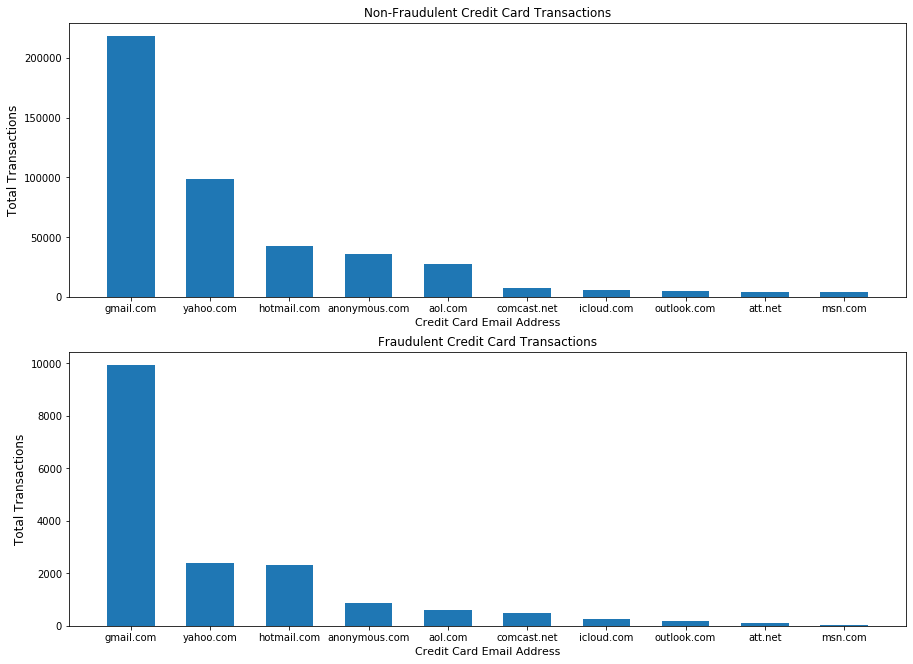

In [476]:
# creating dataframe containing top 10 most common email domains for credit card transactions
index_p_emaildomain= []
list_top_p_emaildomain = df_eda.P_emaildomain.value_counts().head(10).index
for val in list_top_p_emaildomain:
    index_temp = df_eda[df_eda.P_emaildomain==val].index.values
    index_p_emaildomain.append(index_temp)
index_final = [val for sublist in index_p_emaildomain for val in sublist]
df_p_emaildomain = df_eda.loc[index_final,:]

# creating dataframes for histogram
y_counts = df_p_emaildomain[df_p_emaildomain.isFraud==0].P_emaildomain.value_counts()
x_label = y_counts.index
y_counts_2 = df_p_emaildomain[df_p_emaildomain.isFraud==1].P_emaildomain.value_counts()
x_label_2 = y_counts.index

# creating plots
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
plt.subplots_adjust(top=1.8)

ax[0].set_title("Non-Fraudulent Credit Card Transactions")
ax[0].set_ylabel('Total Transactions', fontsize=12)
ax[0].set_xlabel('Credit Card Email Address', fontsize=11)
ax[0].bar(x_label, y_counts, width=.6)

ax[1].set_title("Fraudulent Credit Card Transactions")
ax[1].set_ylabel('Total Transactions', fontsize=12)
ax[1].set_xlabel('Credit Card Email Address', fontsize=11)
ax[1].bar(x_label_2, y_counts_2, width=.6)
plt.show()

In [317]:
# plt.hist(df_eda_fraud[df_eda_fraud.addr2.notnull()].addr2.value_counts().head(10), bins=5)
# plt.title('addr2 - Fraud')
# plt.show()
# plt.hist(df_eda_not_fraud[df_eda_not_fraud.addr2.notnull()].addr2.value_counts().head(10))
# plt.title('addr2 - Not Fraud')
# plt.show()

# # plt.hist(df_eda_fraud.addr2)

In [259]:
# What's the distribution of TransactionAmt for fraud?
# What's the distribution of ProductCD by isFraud? 
# card4 FINISHED
# card6 FINISHED
# P_emaildomain FINISHED

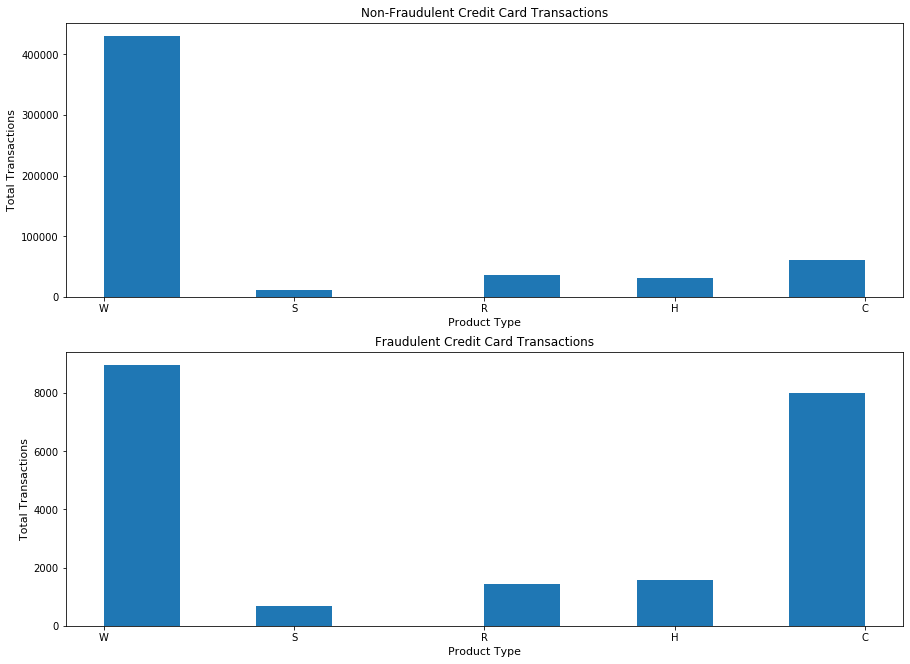

In [477]:
df_productcd_notfraud = df_raw[df_raw.isFraud==0].ProductCD.sort_values(ascending=False)
df_productcd_fraud = df_raw[df_raw.isFraud==1].ProductCD.sort_values(ascending=False)
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
plt.subplots_adjust(top=1.8)

ax[0].set_title("Non-Fraudulent Credit Card Transactions")
ax[0].set_ylabel('Total Transactions', fontsize=11)
ax[0].set_xlabel('Product Type', fontsize=11)
ax[0].hist(df_productcd_notfraud)

ax[1].set_title("Fraudulent Credit Card Transactions")
ax[1].set_ylabel('Total Transactions', fontsize=11)
ax[1].set_xlabel('Product Type', fontsize=11)
ax[1].hist(df_productcd_fraud)
plt.show()

# NEXT, clean up and make this asthetic

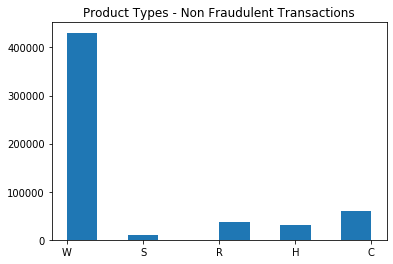

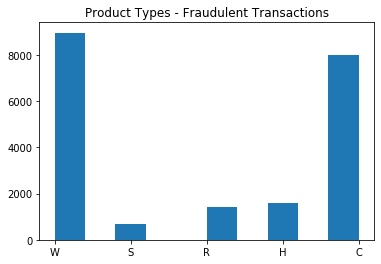

In [250]:
# EDA ProductCD, add asthetics later.
plt.hist(df_raw[df_raw.isFraud==0].ProductCD.sort_values(ascending=False))
plt.title("Product Types - Non Fraudulent Transactions")
plt.show()
plt.hist(df_raw[df_raw.isFraud==1].ProductCD.sort_values(ascending=False))
plt.title("Product Types - Fraudulent Transactions")
plt.show()

In [366]:
# print('\nNOT FRAUD')
# print(df_eda_not_fraud.DeviceType.value_counts())
# print('\nFRAUD')
# print(df_eda_fraud.DeviceType.value_counts())
# print('\nNOT FRAUD')
# print(df_eda_not_fraud.DeviceInfo.value_counts())
# print('\nFRAUD')
# print(df_eda_fraud.DeviceInfo.value_counts())

# the goal of EDA is to look at our data points and figure out what insights we can find from the columns
# that we are already using within our features.. 
# we might consider taking addr2 and getting rid of most variables and keeping only those that improve our score
# after seeing one of them have .61 majority values. 

In [ ]:
# what are the most interesting insights? What questions do I want to know? 
# Which devices have the most fraud? id_31
# Which browser has the most fraud? id_30
# Look at screen res to see if you see anything interesting. id_33

In [149]:
# df_eda[(df_eda.id_30.str.contains('Android')) & df_eda.id_30.notnull()].id_30
df_eda[(df_eda.id_30.str.contains('Windows')) & df_eda.id_30.notnull()].id_30

17        Windows 10
66        Windows 10
93        Windows 10
138       Windows 10
156       Windows 10
             ...    
590347    Windows 10
590442     Windows 7
590447     Windows 7
590495     Windows 7
590506     Windows 7
Name: id_30, Length: 36739, dtype: object

In [160]:
df_eda['Device'][4] = 'test'
df_eda['Device']

0          NaN
1          NaN
2          NaN
3          NaN
4         test
          ... 
590535     NaN
590536     NaN
590537     NaN
590538     NaN
590539     NaN
Name: Device, Length: 590540, dtype: object

In [223]:
# id_30 - shows Desktop and Mobile
df_eda['Device'] = df_eda['id_30']

temp_len = 0
for val in ['Android', 'Mac', 'iOS', 'Linux', 'Windows', 'func', 'other']:
    col_index = df_eda[(df_eda.id_30.str.contains(val)) 
                       & df_eda.id_30.notnull()].id_30.index
    
    if val=='Mac':
        df_eda['Device'][col_index] = 'Macbook'
    elif val=='iOS':
        df_eda['Device'][col_index] = 'iPad'
    elif val=='Android':
        df_eda['Device'][col_index] = 'Android Tablet'
    # NEXT, get the next if statement working, then clean this up and create more EDA out of this.. 
    elif (val=='func') | (val=='other'):
        df_eda['Device'][col_index] = 'Windows' 
        
    else:
        df_eda['Device'][col_index] = val

df_eda['Device'].unique()


id_30 PC, Mac, Tablet 77565


array([nan, 'Android Tablet', 'iPad', 'Macbook', 'Windows', 'Linux'],
      dtype=object)

In [225]:
col_device_not_fraud = df_eda[(df_eda['Device'].notnull()) 
                            & (df_eda.isFraud==0)].Device
col_device_fraud = df_eda[(df_eda['Device'].notnull()) 
                          & (df_eda.isFraud==1)].Device

In [237]:
plt.barh(col_device_not_fraud.sort_values())

TypeError: barh() missing 1 required positional argument: 'width'

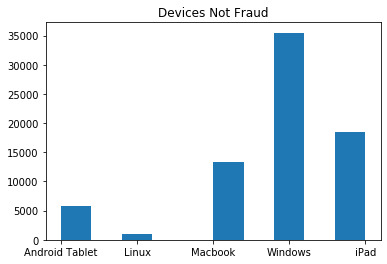

In [238]:
plt.hist(col_device_not_fraud.sort_values())
plt.title('Devices Not Fraud')
plt.show()

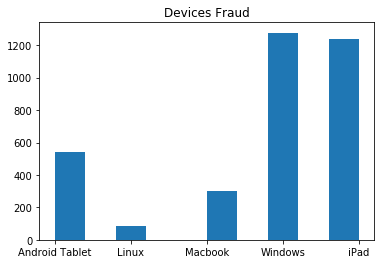

In [227]:
plt.hist(col_device_fraud.sort_values())
plt.title('Devices Fraud')
plt.show()

In [194]:
# print(list(df_eda.DeviceInfo.unique()))
# print(list(df_eda.columns))
mode_col_device = df_eda[(df_eda.id_30.str.contains(val)) & df_eda.id_30.notnull()].id_30.mode()[0]
mode_col_device

'Windows 10'

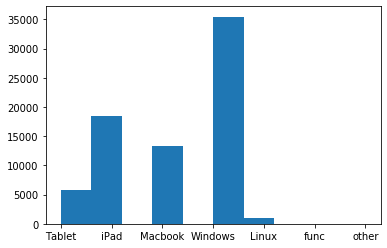

In [190]:
# plt.
plt.hist(df_eda[(df_eda['Device'].notnull()) & (df_eda.isFraud==0)].Device);

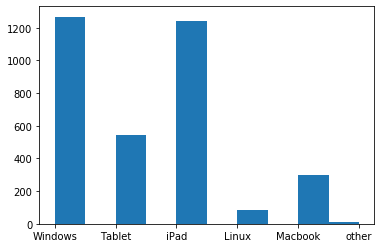

In [191]:
plt.hist(df_eda[(df_eda['Device'].notnull()) & (df_eda.isFraud==1)].Device);

In [168]:
print(list(df_eda.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [153]:
6303 +13580 +19782

39665

In [134]:
# id_31
print('id_31: browser', df_eda[df_eda.id_31.notnull()].id_31.shape[0])
df_eda[df_eda.id_31.notnull()].id_31.unique()
# df_eda[df_eda.id_31.notnull()].id_31

id_31: browser 140282


array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0',
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile safari 

In [137]:
# id_33
print('id_33: screen resolution', df_eda[df_eda.id_33.notnull()].id_33.shape[0])
df_eda[df_eda.id_33.notnull()].id_33.unique()
# df_eda[df_eda.id_33.notnull()].id_33

id_33: screen resolution 73289


array(['2220x1080', '1334x750', '1280x800', '1366x768', '1920x1080',
       '1680x1050', '1136x640', '5120x2880', '2880x1800', '1920x1200',
       '2560x1600', '2048x1536', '1024x768', '1280x720', '2560x1440',
       '2208x1242', '2001x1125', '1440x900', '1600x900', '2672x1440',
       '1280x1024', '960x540', '2732x2048', '2436x1125', '2048x1152',
       '2960x1440', '1024x600', '855x480', '4096x2304', '2160x1440',
       '2562x1442', '801x480', '2736x1824', '3441x1440', '2880x1620',
       '3840x2160', '1638x922', '1280x768', '1360x768', '1280x960',
       '3440x1440', '1152x720', '1280x1025', '3360x2100', '2304x1296',
       '1152x864', '3200x1800', '2112x1188', '2224x1668', '2400x1350',
       '2000x1125', '1600x1000', '2560x1080', '1728x972', '3000x2000',
       '1024x640', '3840x2400', '2304x1440', '1280x600', '1400x1050',
       '1600x1200', '3201x1800', '1356x900', '1344x756', '1624x1080',
       '1536x864', '1800x1125', '1920x1281', '2961x1442', '1366x1024',
       '1344x840', 

In [104]:
# df_eda[(df_eda.id_30.notnull()) | (df_eda.id_30.notnull())].id_30.unique()
df_eda[(df_eda.id_30.notnull()) | (df_eda.id_30.notnull())].id_30.unique()

array(['Android 7.0', 'iOS 11.1.2', 'Mac OS X 10_11_6', 'Windows 10',
       'Android', 'Linux', 'iOS 11.0.3', 'Mac OS X 10_7_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'iOS 11.1.0',
       'Mac OS X 10_9_5', 'Windows 7', 'Windows 8.1', 'Mac', 'iOS 10.3.3',
       'Mac OS X 10.12', 'Mac OS X 10_10_5', 'Mac OS X 10_11_5',
       'iOS 9.3.5', 'Android 5.1.1', 'Android 7.1.1', 'Android 6.0',
       'iOS 10.3.1', 'Mac OS X 10.9', 'iOS 11.1.1', 'Windows Vista',
       'iOS 10.3.2', 'iOS 11.0.2', 'Mac OS X 10.11', 'Android 8.0.0',
       'iOS 10.2.0', 'iOS 10.2.1', 'iOS 11.0.0', 'Mac OS X 10.10',
       'Mac OS X 10_12_3', 'Mac OS X 10_12', 'Android 6.0.1', 'iOS',
       'Mac OS X 10.13', 'Mac OS X 10_12_5', 'Mac OS X 10_8_5',
       'iOS 11.0.1', 'iOS 10.0.2', 'Android 5.0.2', 'Windows XP',
       'iOS 11.2.0', 'Mac OS X 10.6', 'Windows 8', 'Mac OS X 10_6_8',
       'Mac OS X 10_11_4', 'Mac OS X 10_12_1', 'iOS 10.1.1',
       'Mac OS X 10_11_3', 'Mac OS X 10_12_4', 'Mac OS X 10_13_2

In [87]:
df_eda[df_eda.id_31.notnull()].id_31

4             samsung browser 6.2
8              mobile safari 11.0
10                    chrome 62.0
11                    chrome 62.0
16                    chrome 62.0
                   ...           
590521    chrome 66.0 for android
590526    chrome 55.0 for android
590529    chrome 65.0 for android
590531                chrome 66.0
590534    chrome 66.0 for android
Name: id_31, Length: 140282, dtype: object

In [106]:
df_eda[(df_eda.id_31.notnull()) | (df_eda.id_34 != 'nan')].id_30.unique()

array([nan, 'Android 7.0', 'iOS 11.1.2', 'Mac OS X 10_11_6', 'Windows 10',
       'Android', 'Linux', 'iOS 11.0.3', 'Mac OS X 10_7_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'iOS 11.1.0',
       'Mac OS X 10_9_5', 'Windows 7', 'Windows 8.1', 'Mac', 'iOS 10.3.3',
       'Mac OS X 10.12', 'Mac OS X 10_10_5', 'Mac OS X 10_11_5',
       'iOS 9.3.5', 'Android 5.1.1', 'Android 7.1.1', 'Android 6.0',
       'iOS 10.3.1', 'Mac OS X 10.9', 'iOS 11.1.1', 'Windows Vista',
       'iOS 10.3.2', 'iOS 11.0.2', 'Mac OS X 10.11', 'Android 8.0.0',
       'iOS 10.2.0', 'iOS 10.2.1', 'iOS 11.0.0', 'Mac OS X 10.10',
       'Mac OS X 10_12_3', 'Mac OS X 10_12', 'Android 6.0.1', 'iOS',
       'Mac OS X 10.13', 'Mac OS X 10_12_5', 'Mac OS X 10_8_5',
       'iOS 11.0.1', 'iOS 10.0.2', 'Android 5.0.2', 'Windows XP',
       'iOS 11.2.0', 'Mac OS X 10.6', 'Windows 8', 'Mac OS X 10_6_8',
       'Mac OS X 10_11_4', 'Mac OS X 10_12_1', 'iOS 10.1.1',
       'Mac OS X 10_11_3', 'Mac OS X 10_12_4', 'Mac OS X 10

In [103]:
df_eda[(df_eda.id_34.notnull()) | (df_eda.id_34!='nan')].id_31df_eda[(df_eda.id_34.notnull()) & (df_eda.id_34=='nan')].id_34.unique().unique()

array([nan, 'match_status:2', 'match_status:1', 'match_status:0',
       'match_status:-1'], dtype=object)

In [101]:
df_eda[df_eda.id_34=='nan'].id_34.unique()

array([], dtype=object)

In [ ]:
plt.hist(df_eda[df_eda.id_31.notnull()].id_31)

In [83]:
df_device = df_eda[(df_eda.id_31.notnull()) & (df_eda.isFraud==1)].id_31
# plt.hist(df_eda[(df_eda.id_31.notnull()) & (df_eda.isFraud==1)].id_31);

240       chrome 54.0 for android
243       chrome 54.0 for android
245       chrome 54.0 for android
288           chrome 62.0 for ios
367                       firefox
                   ...           
590351    chrome 66.0 for android
590354    chrome 66.0 for android
590364        samsung browser 6.4
590368         mobile safari 11.0
590526    chrome 55.0 for android
Name: id_31, Length: 11171, dtype: object

In [11]:
# show stacked graph of what is fraud and not fraud. So this would show percentage fraud not fraud
# find graph stacked, show bar changes by color
card6_non_fraud_count = [0.729495, 0.235439, 30, 15]
card6_fraud_count = [0.018141, 0.016849, 0, 0]
plt.bar()

debit              430796
credit             139036
debit or credit        30
charge card            15
Name: card6, dtype: int64

(array([68.,  5.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([1.00000e+00, 2.11640e+03, 4.23180e+03, 6.34720e+03, 8.46260e+03,
        1.05780e+04, 1.26934e+04, 1.48088e+04, 1.69242e+04, 1.90396e+04,
        2.11550e+04]),
 <a list of 10 Patch objects>)

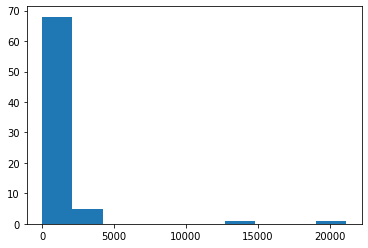

In [30]:
plt.hist(df_eda.id_30.value_counts());

In [28]:
# df_eda[col_i]
col_i = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
df_eda[col_i].describe()
for col in df_eda[col_i].columns:
    if df_eda[col].dtype == 'object':
        print('\n'+col)
        print(df_eda[col].unique())


id_12
[nan 'NotFound' 'Found']

id_15
[nan 'New' 'Found' 'Unknown']

id_16
[nan 'NotFound' 'Found']

id_23
[nan 'IP_PROXY:TRANSPARENT' 'IP_PROXY:ANONYMOUS' 'IP_PROXY:HIDDEN']

id_27
[nan 'Found' 'NotFound']

id_28
[nan 'New' 'Found']

id_29
[nan 'NotFound' 'Found']

id_30
[nan 'Android 7.0' 'iOS 11.1.2' 'Mac OS X 10_11_6' 'Windows 10' 'Android'
 'Linux' 'iOS 11.0.3' 'Mac OS X 10_7_5' 'Mac OS X 10_12_6'
 'Mac OS X 10_13_1' 'iOS 11.1.0' 'Mac OS X 10_9_5' 'Windows 7'
 'Windows 8.1' 'Mac' 'iOS 10.3.3' 'Mac OS X 10.12' 'Mac OS X 10_10_5'
 'Mac OS X 10_11_5' 'iOS 9.3.5' 'Android 5.1.1' 'Android 7.1.1'
 'Android 6.0' 'iOS 10.3.1' 'Mac OS X 10.9' 'iOS 11.1.1' 'Windows Vista'
 'iOS 10.3.2' 'iOS 11.0.2' 'Mac OS X 10.11' 'Android 8.0.0' 'iOS 10.2.0'
 'iOS 10.2.1' 'iOS 11.0.0' 'Mac OS X 10.10' 'Mac OS X 10_12_3'
 'Mac OS X 10_12' 'Android 6.0.1' 'iOS' 'Mac OS X 10.13'
 'Mac OS X 10_12_5' 'Mac OS X 10_8_5' 'iOS 11.0.1' 'iOS 10.0.2'
 'Android 5.0.2' 'Windows XP' 'iOS 11.2.0' 'Mac OS X 10.6' 'Window

In [418]:
# df_eda_not_fraud[col]
print(list(df_features.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 

In [ ]:
# hypothesize... the percentage of fraud charges are more likely to be debit or credit.
# how do we represent the data... WE need ratios of some kind.. we need to show the ratio of debit, credit, etc.
# the ratio of non fraud or fraud or entire dataset... ? 
# what does fraud versus non fraud tell us? 
# we will see the percentage of non fraud transactions from each card..
# we will see the percentage of fraud transactions from each card type...
# we need to see this comparison on a bar chart...that wouldn't help us.. 


In [416]:
len_df_not_fraud = df_eda_not_fraud.shape[0]
df_temp = df_eda_not_fraud[col].value_counts().reset_index()
col_val = df_eda_not_fraud[col].value_counts().reset_index()[col]/len_df_not_fraud
col_val = pd.Series(col_val, name='DeviceInfo_perc')
df_temp = pd.concat([df_temp,col_val],axis=1)
print(np.sum(df_eda_not_fraud[col].isnull()))
df_temp
# what are we doing? we have 300,000 missing values for the df_eda_not_fraud aspect, we really can't use this 
# for EDA when we have so much missing information.. 


459818


,index,DeviceInfo,DeviceInfo_perc
0,Windows,44601,0.078264
1,iOS Device,18542,0.032537
2,MacOS,12295,0.021575
3,Trident/7.0,7344,0.012887
4,rv:11.0,1825,0.003202
...,...,...,...
1735,U FEEL LITE Build/MRA58K,1,0.000002
1736,Neffos X1 Max Build/NRD90M,1,0.000002
1737,GT-I9195L,1,0.000002
1738,LS5,1,0.000002


In [417]:
sum(df_temp.DeviceInfo)

110059

In [412]:
len_df_fraud = df_eda_fraud.shape[0]
df_temp = df_eda_fraud[col].value_counts().reset_index()
col_val = df_eda_fraud[col].value_counts().reset_index()[col]/len_df_fraud
col_val = pd.Series(col_val, name='DeviceInfo_perc')
df_temp = pd.concat([df_temp,col_val],axis=1)
df_temp


,index,DeviceInfo,DeviceInfo_perc
0,Windows,3121,0.151043
1,iOS Device,1240,0.060011
2,MacOS,278,0.013454
3,hi6210sft Build/MRA58K,180,0.008711
4,SM-A300H Build/LRX22G,169,0.008179
...,...,...,...
415,ZTE-Z956,1,0.000048
416,SAMSUNG SM-G950U Build/NRD90M,1,0.000048
417,Blade A475 Build/LMY47D,1,0.000048
418,SAMSUNG SM-J730GM Build/NRD90M,1,0.000048


In [390]:
# is there a high percentage occurrence of something in our fraud dataframe...? Is there a unique value
# within each column that signifies fraud for us...? Looking at only the fraud_df can we find such info? 
# calculate the percentage value of each occurrence of each unique value in descending order of the 
# null df, then show the insights via EDA... 

# for val in df_eda_fraud['id_30'].unique():

# do a high percentage of these values occur infraud versus non fraud... 

# are a certain percentage of these values high? 
len_df_fraud = df_eda_fraud.shape[0]
for col in df_eda_fraud.columns:
    df_temp = df_eda_fraud[col].value_counts().reset_index()[col]/len_df_fraud 
    
    if df_temp[0] > .1:
        print(col)
#         print(df_eda_fraud[col].unique())
        print(df_eda_fraud[col].value_counts().reset_index())
        print(df_temp.head())
        
# NEXT, we need to tinker with this and figure out if we can derive more insight from what we see in these columns for 
# credit card fraud. We need to decide on which columns to look at closer. 

# df_temp = df_eda_fraud['id_30'].value_counts().reset_index()['id_30']/len_df_fraud
# df_temp.head()

# we need to know if there is a disproportionate amount of certain fraud values then non fraud df
# we need to know if there is a disproportionate amount of fraud values 
# is there a difference between the two... are certain unique values represented more in the fraud_df versus 
# no_fraud_df... we need to do some kind of cross comparison... 


isFraud
   index  isFraud
0      1    20663
0    1.0
Name: isFraud, dtype: float64
ProductCD
  index  ProductCD
0     W       8969
1     C       8008
2     H       1574
3     R       1426
4     S        686
0    0.434061
1    0.387553
2    0.076175
3    0.069012
4    0.033199
Name: ProductCD, dtype: float64
card3
    index  card3
0   150.0  12807
1   185.0   7362
2   144.0    112
3   119.0     70
4   143.0     28
..    ...    ...
57  126.0      1
58  195.0      1
59  183.0      1
60  167.0      1
61  208.0      1

[62 rows x 2 columns]
0    0.619804
1    0.356289
2    0.005420
3    0.003388
4    0.001355
Name: card3, dtype: float64
card4
              index  card4
0              visa  13414
1        mastercard   6496
2          discover    514
3  american express    239
0    0.649180
1    0.314378
2    0.024875
3    0.011567
Name: card4, dtype: float64
card5
    index  card5
0   226.0   8753
1   224.0   3152
2   102.0   1832
3   137.0   1725
4   138.0   1682
5   195.0    681
6   166.0 

     index    D6
0      0.0  4253
1      1.0   415
2      2.0   184
3      3.0   134
4      5.0   103
..     ...   ...
375  502.0     1
376  378.0     1
377  613.0     1
378  456.0     1
379  157.0     1

[380 rows x 2 columns]
0    0.205827
1    0.020084
2    0.008905
3    0.006485
4    0.004985
Name: D6, dtype: float64
D7
     index    D7
0      0.0  4472
1      1.0   243
2      2.0   108
3      3.0    68
4      4.0    56
..     ...   ...
236   97.0     1
237  238.0     1
238  159.0     1
239  155.0     1
240  327.0     1

[241 rows x 2 columns]
0    0.216425
1    0.011760
2    0.005227
3    0.003291
4    0.002710
Name: D7, dtype: float64
D10
     index    D10
0      0.0  10541
1      1.0    542
2      2.0    339
3      3.0    189
4      4.0    147
..     ...    ...
608  303.0      1
609  597.0      1
610  394.0      1
611  295.0      1
612  528.0      1

[613 rows x 2 columns]
0    0.510139
1    0.026230
2    0.016406
3    0.009147
4    0.007114
Name: D10, dtype: float64
D11
     in

Name: V33, dtype: float64
V34
   index   V34
0    0.0  8760
1    1.0  7883
2    2.0    84
3    3.0    36
4    4.0     6
5    6.0     3
6    7.0     2
7    5.0     2
0    0.423946
1    0.381503
2    0.004065
3    0.001742
4    0.000290
Name: V34, dtype: float64
V35
   index   V35
0    0.0  9859
1    1.0  4578
2    2.0   128
3    3.0     2
0    0.477133
1    0.221555
2    0.006195
3    0.000097
Name: V35, dtype: float64
V36
   index   V36
0    0.0  9545
1    1.0  4561
2    2.0   409
3    3.0    50
4    4.0     2
0    0.461937
1    0.220733
2    0.019794
3    0.002420
4    0.000097
Name: V36, dtype: float64
V37
    index    V37
0     1.0  10822
1     2.0   1956
2     3.0    744
3     4.0    288
4     5.0    159
5     6.0    128
6     7.0     97
7     9.0     76
8     8.0     67
9    10.0     49
10   11.0     30
11   21.0     28
12   12.0     23
13   13.0     19
14   17.0     13
15   14.0      8
16   15.0      6
17   16.0      5
18   18.0      5
19   25.0      4
20   19.0      3
21   20.0 

V79
   index   V79
0    0.0  8801
1    1.0  6653
2    2.0   690
3    3.0   202
4    4.0    33
5    6.0     7
6    5.0     1
0    0.425930
1    0.321976
2    0.033393
3    0.009776
4    0.001597
Name: V79, dtype: float64
V80
    index   V80
0     0.0  9021
1     1.0  6584
2     2.0   492
3     3.0   112
4     4.0    79
5     5.0    37
6     7.0    17
7     6.0    16
8     8.0     6
9    10.0     5
10    9.0     5
11   14.0     2
12   13.0     2
13   11.0     2
14   12.0     2
15   18.0     1
16   16.0     1
17   15.0     1
18   19.0     1
19   17.0     1
0    0.436577
1    0.318637
2    0.023811
3    0.005420
4    0.003823
Name: V80, dtype: float64
V81
    index   V81
0     0.0  8998
1     1.0  6120
2     2.0   766
3     3.0   242
4     4.0   125
5     5.0    43
6     6.0    36
7     7.0    21
8     9.0     8
9     8.0     8
10   13.0     4
11   10.0     3
12   11.0     3
13   12.0     3
14   14.0     2
15   18.0     1
16   16.0     1
17   15.0     1
18   19.0     1
19   17.0     1
0   

   index   V110
0    1.0  19826
1    2.0    680
2    3.0     96
3    4.0     31
4    5.0      7
5    7.0      4
6    0.0      1
7    6.0      1
0    0.959493
1    0.032909
2    0.004646
3    0.001500
4    0.000339
Name: V110, dtype: float64
V111
   index   V111
0    1.0  19901
1    2.0    586
2    3.0    107
3    4.0     29
4    5.0     12
5    9.0      4
6    0.0      3
7    6.0      2
8    7.0      1
9    8.0      1
0    0.963122
1    0.028360
2    0.005178
3    0.001403
4    0.000581
Name: V111, dtype: float64
V112
   index   V112
0    1.0  19819
1    2.0    670
2    3.0    108
3    4.0     29
4    5.0     12
5    9.0      4
6    6.0      2
7    7.0      1
8    8.0      1
0    0.959154
1    0.032425
2    0.005227
3    0.001403
4    0.000581
Name: V112, dtype: float64
V113
   index   V113
0    1.0  19883
1    2.0    605
2    3.0    108
3    4.0     29
4    5.0     12
5    9.0      4
6    6.0      2
7    7.0      1
8    0.0      1
9    8.0      1
0    0.962251
1    0.029279
2    0.005

V164
      index  V164
0       0.0  2474
1     200.0   130
2     150.0   129
3     300.0   123
4     100.0   117
..      ...   ...
114    85.0     1
115  4500.0     1
116  1575.0     1
117  1450.0     1
118  1950.0     1

[119 rows x 2 columns]
0    0.119731
1    0.006291
2    0.006243
3    0.005953
4    0.005662
Name: V164, dtype: float64
V165
       index  V165
0        0.0  2285
1      150.0   140
2      300.0   129
3      200.0   127
4      100.0   116
..       ...   ...
174    195.0     1
175     55.0     1
176  14680.0     1
177   1450.0     1
178     70.0     1

[179 rows x 2 columns]
0    0.110584
1    0.006775
2    0.006243
3    0.006146
4    0.005614
Name: V165, dtype: float64
V166
      index  V166
0       0.0  2298
1     300.0   140
2     200.0   130
3     150.0   117
4     100.0   102
..      ...   ...
158  2600.0     1
159   135.0     1
160  2700.0     1
161  1695.0     1
162   660.0     1

[163 rows x 2 columns]
0    0.111213
1    0.006775
2    0.006291
3    0.005662
4  

V188
    index  V188
0     1.0  7128
1     2.0  1727
2     3.0   676
3     0.0   578
4     4.0   353
5     5.0   175
6     6.0   112
7     7.0   105
8    11.0    44
9     9.0    39
10    8.0    35
11   14.0    22
12   10.0    16
13   12.0    13
14   13.0     8
15   15.0     7
16   17.0     7
17   16.0     4
18   18.0     4
19   22.0     3
20   26.0     2
21   25.0     2
22   30.0     2
23   24.0     1
24   28.0     1
25   23.0     1
26   19.0     1
27   20.0     1
28   21.0     1
29   27.0     1
30   29.0     1
0    0.344964
1    0.083579
2    0.032715
3    0.027973
4    0.017084
Name: V188, dtype: float64
V189
    index  V189
0     1.0  6817
1     2.0  1718
2     3.0   796
3     0.0   558
4     4.0   406
5     5.0   215
6     7.0   131
7     6.0   118
8     9.0    66
9     8.0    51
10   11.0    34
11   14.0    30
12   10.0    25
13   15.0    23
14   13.0    20
15   12.0    18
16   17.0    10
17   16.0     7
18   18.0     7
19   19.0     4
20   22.0     3
21   26.0     2
22   25.0    

          index  V210
0      0.000000  9528
1    200.000000    61
2    100.000000    48
3     25.452700    47
4     50.000000    46
..          ...   ...
284   33.050301     1
285   39.998001     1
286   57.036999     1
287   55.035198     1
288   41.043201     1

[289 rows x 2 columns]
0    0.461114
1    0.002952
2    0.002323
3    0.002275
4    0.002226
Name: V210, dtype: float64
V211
           index  V211
0       0.000000  6413
1     150.000000   126
2     300.000000   123
3     200.000000   119
4     100.000000   109
...          ...   ...
2746  196.727493     1
2747   49.181801     1
2748  315.145599     1
2749   37.428600     1
2750  359.982300     1

[2751 rows x 2 columns]
0    0.310362
1    0.006098
2    0.005953
3    0.005759
4    0.005275
Name: V211, dtype: float64
V212
            index  V212
0        0.000000  5935
1      150.000000   135
2      300.000000   131
3      200.000000   122
4      100.000000   113
...           ...   ...
3239   124.223602     1
3240    26.0676

    index  V226
0     0.0  9217
1     1.0   402
2     2.0   222
3     3.0   122
4     4.0    73
5     5.0    49
6     6.0    28
7     7.0    21
8     8.0    15
9     9.0    11
10   10.0     6
11   12.0     3
12   16.0     3
13   15.0     3
14   13.0     3
15   14.0     3
16   11.0     3
17   17.0     2
18   22.0     1
19   19.0     1
20   20.0     1
21   21.0     1
22   18.0     1
23   23.0     1
0    0.446063
1    0.019455
2    0.010744
3    0.005904
4    0.003533
Name: V226, dtype: float64
V227
    index  V227
0     0.0  9374
1     1.0  1249
2     2.0   169
3     3.0    95
4     6.0    35
5     5.0    20
6     4.0    12
7    60.0     4
8    40.0     4
9     7.0     4
10   12.0     3
11   17.0     2
12    8.0     2
13   15.0     1
14    9.0     1
15   11.0     1
16   16.0     1
17   14.0     1
18   13.0     1
19   10.0     1
20   79.0     1
21   32.0     1
0    0.453661
1    0.060446
2    0.008179
3    0.004598
4    0.001694
Name: V227, dtype: float64
V228
    index  V228
0     1.0  5

    index  V251
0     1.0  6701
1     0.0  3029
2     2.0   925
3     3.0   186
4     4.0    74
5     6.0    24
6     5.0    19
7     7.0     6
8    16.0     5
9     8.0     3
10   15.0     2
11   18.0     1
12   12.0     1
13   11.0     1
14    9.0     1
15   13.0     1
16   10.0     1
17   14.0     1
18   17.0     1
0    0.324299
1    0.146591
2    0.044766
3    0.009002
4    0.003581
Name: V251, dtype: float64
V252
    index  V252
0     1.0  8990
1     2.0   718
2     3.0   245
3     4.0   109
4     5.0    45
5     6.0    26
6     7.0    19
7     8.0     8
8     9.0     5
9    16.0     4
10   10.0     3
11   13.0     3
12    0.0     2
13   15.0     2
14   14.0     2
15   12.0     2
16   23.0     1
17   24.0     1
18   17.0     1
19   22.0     1
20   19.0     1
21   20.0     1
22   21.0     1
23   18.0     1
24   11.0     1
0    0.435077
1    0.034748
2    0.011857
3    0.005275
4    0.002178
Name: V252, dtype: float64
V253
    index  V253
0     1.0  8511
1     2.0   902
2     3.0   

V274
           index  V274
0       0.000000  4785
1     300.000000   131
2     150.000000   130
3     200.000000   122
4     100.000000   117
...          ...   ...
3521  188.510498     1
3522   47.127602     1
3523   13.292400     1
3524  276.000793     1
3525  847.740295     1

[3526 rows x 2 columns]
0    0.231573
1    0.006340
2    0.006291
3    0.005904
4    0.005662
Name: V274, dtype: float64
V275
           index  V275
0       0.000000  5011
1     150.000000   131
2     300.000000   123
3     200.000000   120
4     100.000000   112
...          ...   ...
3346   37.097900     1
3347  343.270386     1
3348   18.548901     1
3349   94.194801     1
3350   48.972000     1

[3351 rows x 2 columns]
0    0.242511
1    0.006340
2    0.005953
3    0.005807
4    0.005420
Name: V275, dtype: float64
V276
           index  V276
0       0.000000  7988
1     300.000000   139
2     150.000000   120
3     200.000000   120
4     100.000000   109
..           ...   ...
500   147.552002     1
501  

V300
    index   V300
0     0.0  19425
1     1.0    874
2     2.0    200
3     3.0     76
4     4.0     18
5     5.0     12
6     6.0      4
7    11.0      3
8     7.0      2
9    10.0      1
10    9.0      1
11    8.0      1
0    0.940086
1    0.042298
2    0.009679
3    0.003678
4    0.000871
Name: V300, dtype: float64
V301
    index   V301
0     0.0  19179
1     1.0   1043
2     2.0    233
3     3.0     84
4     4.0     38
5     5.0     19
6     6.0      7
7    10.0      4
8    11.0      3
9     7.0      3
10    9.0      2
11    8.0      2
0    0.928181
1    0.050477
2    0.011276
3    0.004065
4    0.001839
Name: V301, dtype: float64
V302
   index   V302
0    1.0  10310
1    0.0   9528
2    2.0    677
3    3.0    109
4    4.0     28
5    5.0      7
6    7.0      1
7    6.0      1
0    0.498959
1    0.461114
2    0.032764
3    0.005275
4    0.001355
Name: V302, dtype: float64
V303
    index  V303
0     0.0  9435
1     1.0  9278
2     2.0  1361
3     3.0   324
4     4.0   150
5     5

id_04
    index  id_04
0     0.0   6965
1    -8.0     30
2   -11.0     22
3   -12.0     21
4   -13.0     14
5    -5.0     13
6    -6.0     11
7   -10.0     10
8    -4.0      8
9    -2.0      7
10   -9.0      6
11   -7.0      4
12   -3.0      1
0    0.337076
1    0.001452
2    0.001065
3    0.001016
4    0.000678
Name: id_04, dtype: float64
id_05
    index  id_05
0     0.0   6353
1     1.0    767
2     2.0    551
3     3.0    466
4     4.0    356
..    ...    ...
64  -24.0      1
65  -18.0      1
66   36.0      1
67   42.0      1
68  -20.0      1

[69 rows x 2 columns]
0    0.307458
1    0.037119
2    0.026666
3    0.022552
4    0.017229
Name: id_05, dtype: float64
id_06
    index  id_06
0     0.0   6321
1    -1.0    528
2    -5.0    321
3    -9.0    289
4   -10.0    261
..    ...    ...
63  -94.0      1
64  -92.0      1
65  -48.0      1
66  -62.0      1
67  -81.0      1

[68 rows x 2 columns]
0    0.305909
1    0.025553
2    0.015535
3    0.013986
4    0.012631
Name: id_06, dtype: floa

In [290]:
print(df_eda[(df_eda.card6=='debit or credit') | (df_eda.card6=='charge card')])
# are a certain number of these transactions coming from a specific web browser... ? 
# we need the value counts of each browser fraud and non fraud. 
# Are any of these fraudulent transactions happening on 'DeviceType','DeviceInfo','id_31'
# we need to look at value counts for all fraud and non fraud and see if we capture additional info
# for unique value types some how. 

        TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
16408         3003408        0         435569          58.510         W   
23523         3010523        0         600519          19.757         C   
27859         3014859        0         695531          25.000         W   
43216         3030216        0        1036297          58.430         W   
47201         3034201        0        1120297          28.509         C   
47306         3034306        0        1121538          50.604         C   
54633         3041633        0        1279292         512.610         W   
61895         3048895        0        1393922         160.470         W   
67872         3054872        0        1539141         108.430         W   
81130         3068130        0        1737181          57.950         W   
106355        3093355        0        2123924          23.087         C   
110482        3097482        0        2159314          30.950         W   
132025        3119025    

In [280]:
print('not fraud\n')
print(df_eda_not_fraud.card6.sort_values(ascending=False).value_counts())
print('\nfraud\n')
print(df_eda_fraud.card6.sort_values(ascending=False).value_counts())
# we are going to demonstrate statistical analysis in this porfolio project. draw a random bootstrap
# and p-test / t-test to see if we see more fraud with 

not fraud

debit              430796
credit             139036
debit or credit        30
charge card            15
Name: card6, dtype: int64

fraud

debit     10713
credit     9950
Name: card6, dtype: int64


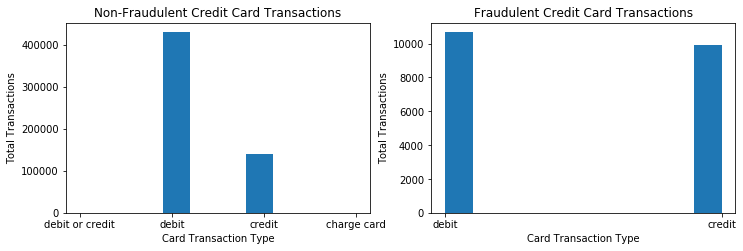

In [273]:
# NEXT, decide and test if we have a combined bar plot... 
fig, ax = plt.subplots(1, 2, figsize=(12,3.5))
ax[0].hist(df_eda_not_fraud.card6.sort_values(ascending=False));
ax[0].set_title("Non-Fraudulent Credit Card Transactions")
ax[0].set_ylabel("Total Transactions")
ax[0].set_xlabel("Card Transaction Type")

ax[1].hist(df_eda_fraud.card6.sort_values(ascending=False));
ax[1].set_title("Fraudulent Credit Card Transactions");
ax[1].set_ylabel("Total Transactions")
ax[1].set_xlabel("Card Transaction Type");

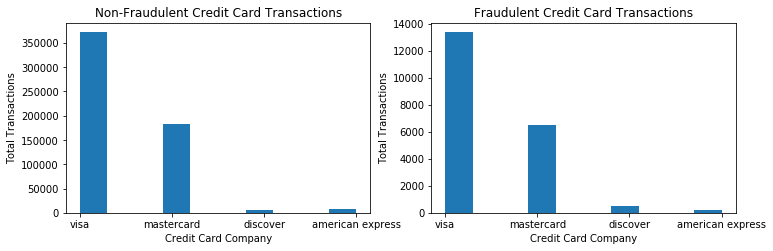

In [266]:
# Transactions for credit card companies IN PROGRESS
fig, ax = plt.subplots(1, 2, figsize=(12,3.5))
ax[0].hist(df_eda_not_fraud.card4.sort_values(ascending=False));
ax[0].set_title("Non-Fraudulent Credit Card Transactions")
ax[0].set_ylabel("Total Transactions")
ax[0].set_xlabel("Credit Card Company")

ax[1].hist(df_eda_fraud.card4.sort_values(ascending=False));
ax[1].set_title("Fraudulent Credit Card Transactions");
ax[1].set_ylabel("Total Transactions")
ax[1].set_xlabel("Credit Card Company");


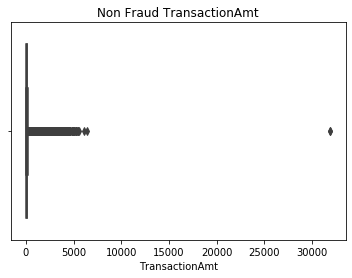

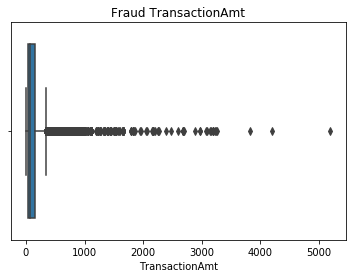

In [297]:
# TransactionAmt 
df_eda_not_fraud = df_eda[df_eda.isFraud==0]['TransactionAmt']
df_eda_fraud = df_eda[df_eda.isFraud==1]['TransactionAmt']
sns.boxplot(df_eda_not_fraud);
plt.title("Non Fraud TransactionAmt")
plt.show()
sns.boxplot(df_eda_fraud);
plt.title("Fraud TransactionAmt")
plt.show()

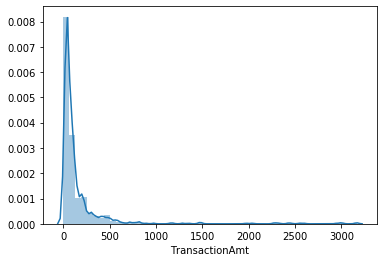

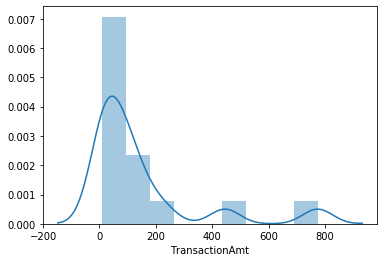

In [177]:
sns.distplot(df_eda[df_eda.isFraud==0]['TransactionAmt']);
plt.show()
sns.distplot(df_eda[df_eda.isFraud==1]['TransactionAmt']);
plt.show()

In [188]:
# sns.distplot(df_card4_types, axlabel=df_card4_types.index)

In [ ]:
####################################

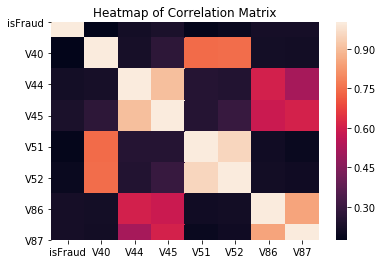

,isFraud,V40,V44,V45,V51,V52,V86,V87
isFraud,1.000000,0.174672,0.217870,0.235436,0.182007,0.195492,0.222343,0.221568
V40,0.174672,1.000000,0.225232,0.271469,0.744831,0.745758,0.217055,0.213533
V44,0.217870,0.225232,1.000000,0.905537,0.257145,0.251881,0.604776,0.515480
V45,0.235436,0.271469,0.905537,1.000000,0.257400,0.296102,0.585396,0.608788
V51,0.182007,0.744831,0.257145,0.257400,1.000000,0.954315,0.212453,0.196567
V52,0.195492,0.745758,0.251881,0.296102,0.954315,1.000000,0.215183,0.207535
V86,0.222343,0.217055,0.604776,0.585396,0.212453,0.215183,1.000000,0.850021
V87,0.221568,0.213533,0.515480,0.608788,0.196567,0.207535,0.850021,1.000000


In [5]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

corr = df_features.corr()
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
plt.show()
corr2

In [ ]:
# plt.figure(figsize=(14,4))
# sns.barplot(x='V44', y='V44', hue='isFraud', data=df_train)
# plt.show()

# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.show()

# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
# ###DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

#### Applying PCA (2 components)

In [ ]:
# # standardizing our data, which is required for PCA.
# scaled_X = StandardScaler().fit_transform(X)

# # PCA instantiate and fit 
# pca = PCA(n_components=2)
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
# print(X_pca.shape)
# X_pca.head()

# # two principal components scatter plot
# plt.figure(figsize=(8,6))
# plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')

# # explaining vaariance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

#### Applying PCA to all features (all components)

### EDA

In [ ]:
# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr1 versus addr2')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.title('Addr1 Distribution')
# plt.show()

In [ ]:
# Hypothesis: less occurring email domains are more likely to have higher fraud_perc because they are 
# perhaps an email provider with less resources. The card that the holder has attached to certain email
# addresses puts them at higher risk for fraud. 

### Feature Engineering Class

In [7]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000] ### delete
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('After running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000] ### delete
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat ### delete?
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1) # comment out when 0:1000
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1) ### delete
        print('Dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = [] ### testing
        print("final dataframe created.")
        
    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        self._apply_pca(X, y)
        self._apply_smote()

    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            X, y = self._drop_col_id_target(df_feat)
            X = self._pca(X)
            sm = SMOTE(random_state=42, n_jobs=-1)
            mod.X_features, mod.y_target = sm.fit_sample(X, y)
            print('tuning dataframe created.')
        else:
            print('bool_create_tuning_df set to false.')

    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X_pca = self._pca(X)
            self._split_dataframe(X_pca, y)
            print('PCA applied.')
        else:
            print("bool_apply_pca set to false.")
            self._split_dataframe(X, y)
            
    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(X, 
                                                                            y, 
                                                                            test_size=0.1, 
                                                                            random_state=42)

    def _apply_smote(self):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            mod.X_train, mod.y_train = sm.fit_sample(mod.X_train, 
                                                     mod.y_train)
            print("smote applied.")
        else:
            print("bool_apply_smote set to false.")
        
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("Keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values) # call _create_dict 
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat

fe = FeatureEngineering()

bool_apply_pca = True
bool_apply_smote = True
df_feat_1000 = False
bool_create_tuning_df = True
bool_drop_col = True
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')

fe.create_final_df()

# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

# NEXT, fix bugs in fe, then check to see that mod.X_features works, then check mod.y_target. check
# model scores right, then clean up code, then test the new def we created. then go back to 
# model tuning 

After running final_features, run create_final_df.
After running final_features, run create_final_df.
Keeping original feature card5
Keeping original feature V317
Keeping original feature V69
Keeping original feature D1
Keeping original feature D3
Keeping original feature D4
Keeping original feature D11
Dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
PCA applied.
smote applied.
tuning dataframe created.
final dataframe created.


In [8]:
mod.X_features

array([[-1.67914422e+00, -3.49748207e-01,  2.80228703e+00, ...,
         1.57956336e-03, -1.56985656e-02,  9.08141843e-03],
       [-4.84194542e-01, -5.19750838e-01,  1.52053537e+00, ...,
        -5.22400203e-03,  2.79034648e-03,  5.13881253e-03],
       [-1.97177288e+00, -5.58737441e-01,  2.23148967e+00, ...,
        -1.35586758e-02,  1.05160373e-02, -8.64544766e-03],
       ...,
       [-1.64099167e+00,  8.89749116e-01,  1.17072521e+00, ...,
        -7.15880176e-02, -8.44372948e-02, -1.05563052e-01],
       [-1.17677409e+00,  6.76745308e-01,  3.62591540e+00, ...,
        -2.51628523e-02,  7.98621556e-03,  4.89218013e-03],
       [ 1.58819852e+01, -1.94379551e+00, -1.01577876e+00, ...,
         1.45069948e-01,  1.93907058e-01,  2.66702324e-01]])

In [16]:
# we need to add delete functions to our created dataframes potentially..
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)

mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')

In [5]:
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')
mod.X_features = mod.X_features.drop('Unnamed: 0', axis=1)
mod.y_target = mod.y_target.drop('Unnamed: 0', axis=1)

In [6]:
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')


In [7]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current)


In [ ]:
# model_current = DecisionTreeClassifier(random_state=42)
# mod.create_df_score_model(model_current)


In [8]:
# bool_predict_proba = False
# model_current = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [40]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current) 


In [4]:
class Model():
    def __init__(self, bool_smote):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        
    def create_df_score_model(self, model_current):
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, elapsed_time = self.add_model(model_current) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, 
                                                       elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model_current)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred = self._predict(model)
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred = self._predict_proba(model)
            return y_pred 
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            y_pred_class = self._predict_proba_threshold(y_pred_prob)
            return y_pred_class
        except:
            print("Model does not have predict_proba attribute.")
            
    def _predict_proba_threshold(self, y_pred_prob):
        for threshold in [.1, .15, .2, .25, .3, .35, .4, .45, .5]:
            print('threshold: ', threshold)
            y_pred_class = binarize(y_pred_prob, threshold)[:,1]
            print('roc auc score:', roc_auc_score(mod.y_test, y_pred_class))
            print('confusion matrix:\n', confusion_matrix(mod.y_test, y_pred_class))
        return y_pred_class
            
#     def _create_roc_curve(self, y_pred_class):
#         fpr, tpr, thresholds = roc_curve(mod.y_test, y_pred_class)
#         plt.plot(fpr, tpr)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.title("ROC curve for classifier")
#         plt.xlabel("False Positive Rate (1 - Specificity)")
#         plt.ylabel("True Positive Rate (Sensitivity)")
#         plt.grid(True)
#         plt.show()
        
    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_scores(y_pred, 
                                                                  elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print("roc score:", roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\nPrinting df_scores...\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            df_feat_rank = self._feat_import_create_df(model)
            self._feat_import_create_plot(df_feat_rank)
            print(df_feat_rank[0:10].reset_index(drop=True))
        except:
            print("\nmodel does not have _feature_importance attribute.")
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(fe.df_feat.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        
mod = Model(bool_smote=True)      

# then Consider creating fe from TransactionAmt
# NEXT, do more EDA

In [122]:
# model_xgbc = XGBClassifier()
# model_xgbc.fit(mod.X_train, mod.y_train)
# y_pred_xgbc = model_xgbc.predict(mod.X_test)
# print(classification_report(mod.y_test, y_pred_xgbc))
# print(confusion_matrix(mod.y_test, y_pred_xgbc))

In [ ]:
# model_cbc = CatBoostClassifier()
# model_cbc.fit(mod.X_train, mod.y_train)
# y_pred_cbc = model_cbc.predict(mod.y_test)
# print(classification_report(mod.y_test, y_pred_cbc))
# print(confusion_matrix(mod.y_test, y_pred_cbc))


## Model Tuning

### RFC Tuning

In [ ]:
# NEXT, before we keep tuning, we need to score on whole dataframe, so fix and test our method...
# then we. need to add roc_score to tuning method... or once we get rfc results we can test to see if
# it makes a difference or see if there is some kind of built in method we can use. 

# NEXT, we need to set up tuning for LogisticRegression, then XGBoostClassifier


In [12]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=7, random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [1,3,5,7]
colsample_bytree = [1,3,5,7]
colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
colsample_bynode = [1,3,5,7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, learning_rate=learning_rate, booster=booster, 
                       subsample=subsample, colsample_bytree=colsample_bytree, 
                       colsample_bylevel=colsample_bylevel, colsample_bynode=colsample_bynode,
                       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=5, verbose=1, n_jobs=7, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [9]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=7, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15, None]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

# n_estimators = [50,75,100,125]
# criterion = ['gini']
# max_depth = [2,3,4,5,6,7,None]
# min_samples_split = [6,7,8,9]
# min_samples_leaf = [1,2]
# min_weight_fraction_leaf = [0]
# max_features = ['auto', 'sqrt', 'log2', None]
# max_leaf_nodes = [None]
# min_impurity_decrease = [0]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=7, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])


In [60]:
#### LR Tuning ####
lr = LogisticRegression(n_jobs=3, random_state=42, verbose=1)

penalty = ['l1', 'l2', 'elasticnet', 'none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, tol=tol, C=C, 
                       fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, class_weight=class_weight,
                       solver=solver, max_iter=max_iter,
                       multi_class=multi_class, l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=5, verbose=10, n_jobs=3, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [61]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11, None]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=3, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [41]:
model_cbc = CatBoostClassifier(learning_rate=.1, random_state=42, thread_count=-1)
model_cbc.fit(mod.X_features, mod.y_target)

0:	learn: 0.6544898	total: 929ms	remaining: 15m 27s
1:	learn: 0.6249446	total: 1.84s	remaining: 15m 16s
2:	learn: 0.6016028	total: 3.28s	remaining: 18m 10s
3:	learn: 0.5816481	total: 4.46s	remaining: 18m 31s
4:	learn: 0.5655440	total: 6.06s	remaining: 20m 5s
5:	learn: 0.5526336	total: 7s	remaining: 19m 18s
6:	learn: 0.5399379	total: 7.87s	remaining: 18m 36s
7:	learn: 0.5300839	total: 8.72s	remaining: 18m 1s
8:	learn: 0.5214796	total: 9.47s	remaining: 17m 23s
9:	learn: 0.5139839	total: 10.2s	remaining: 16m 50s
10:	learn: 0.5073609	total: 11.2s	remaining: 16m 43s
11:	learn: 0.5022986	total: 12.4s	remaining: 17m 1s
12:	learn: 0.4973163	total: 13.7s	remaining: 17m 23s
13:	learn: 0.4925372	total: 14.8s	remaining: 17m 20s
14:	learn: 0.4885491	total: 16s	remaining: 17m 28s
15:	learn: 0.4846308	total: 16.8s	remaining: 17m 12s
16:	learn: 0.4813124	total: 17.7s	remaining: 17m 2s
17:	learn: 0.4783247	total: 19.5s	remaining: 17m 41s
18:	learn: 0.4754238	total: 20.3s	remaining: 17m 28s
19:	learn: 0

154:	learn: 0.3647690	total: 3m 5s	remaining: 16m 49s
155:	learn: 0.3643453	total: 3m 6s	remaining: 16m 48s
156:	learn: 0.3639767	total: 3m 7s	remaining: 16m 48s
157:	learn: 0.3635476	total: 3m 8s	remaining: 16m 46s
158:	learn: 0.3632361	total: 3m 9s	remaining: 16m 43s
159:	learn: 0.3627946	total: 3m 11s	remaining: 16m 42s
160:	learn: 0.3622907	total: 3m 11s	remaining: 16m 40s
161:	learn: 0.3618861	total: 3m 12s	remaining: 16m 36s
162:	learn: 0.3615091	total: 3m 13s	remaining: 16m 32s
163:	learn: 0.3611054	total: 3m 14s	remaining: 16m 29s
164:	learn: 0.3607151	total: 3m 15s	remaining: 16m 26s
165:	learn: 0.3602508	total: 3m 17s	remaining: 16m 30s
166:	learn: 0.3598519	total: 3m 17s	remaining: 16m 26s
167:	learn: 0.3595129	total: 3m 19s	remaining: 16m 26s
168:	learn: 0.3591616	total: 3m 20s	remaining: 16m 26s
169:	learn: 0.3587460	total: 3m 23s	remaining: 16m 31s
170:	learn: 0.3583586	total: 3m 25s	remaining: 16m 35s
171:	learn: 0.3579535	total: 3m 27s	remaining: 16m 37s
172:	learn: 0.3

KeyboardInterrupt: 

In [ ]:
pred_cbc = model_cbc.predict(X_test)

In [ ]:
roc_auc_score(mod.y_test, pred_cbc)

In [28]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       n_estimators=n_estimators,
                       subsample=subsample,
                       depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=5, verbose=10, n_jobs=7, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 11.2min


KeyboardInterrupt: 

In [21]:
# cbc.fit(x)
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                            test_size=0.1, 
                                                                            random_state=42)

In [22]:
cbc.fit(mod.X_train, mod.y_train)

Learning rate set to 0.198909
0:	learn: 0.6219019	total: 1.15s	remaining: 19m 8s
1:	learn: 0.5770163	total: 2.99s	remaining: 24m 51s
2:	learn: 0.5487995	total: 4.41s	remaining: 24m 25s
3:	learn: 0.5278432	total: 5.62s	remaining: 23m 19s
4:	learn: 0.5132952	total: 7.21s	remaining: 23m 54s
5:	learn: 0.5014962	total: 8.52s	remaining: 23m 31s
6:	learn: 0.4926963	total: 9.61s	remaining: 22m 43s
7:	learn: 0.4847921	total: 10.6s	remaining: 21m 59s
8:	learn: 0.4778748	total: 11.7s	remaining: 21m 33s
9:	learn: 0.4731304	total: 13s	remaining: 21m 28s
10:	learn: 0.4687837	total: 14s	remaining: 20m 57s
11:	learn: 0.4648911	total: 15s	remaining: 20m 32s
12:	learn: 0.4612255	total: 15.9s	remaining: 20m 10s
13:	learn: 0.4581508	total: 16.9s	remaining: 19m 49s
14:	learn: 0.4548853	total: 18.8s	remaining: 20m 37s
15:	learn: 0.4513931	total: 20.5s	remaining: 21m 1s
16:	learn: 0.4485468	total: 22s	remaining: 21m 12s
17:	learn: 0.4457924	total: 23.6s	remaining: 21m 29s
18:	learn: 0.4435485	total: 24.8s	re

KeyboardInterrupt: 

In [ ]:
pred_cbc = cbc.predict(mod.X_test)
confusion_matrix(y_test, pred_cbc)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0.56      2109

    accuracy                           0.97     59054
   macro avg       0.78      0.77      0.77     59054
weighted avg       0.97      0.97      0.97     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
333     addr1_fe  682.0  19343.0   0.06

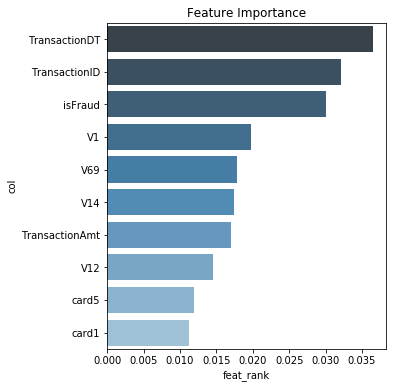

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186
Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
roc score: 0.7653269954567143
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     56945
           1       0.57      0.55      0

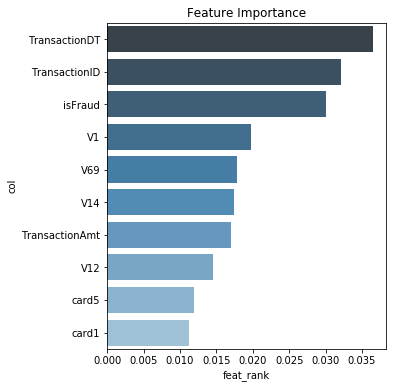

              col  feat_rank
0   TransactionDT   0.036505
1   TransactionID   0.032122
2         isFraud   0.030023
3              V1   0.019718
4             V69   0.017775
5             V14   0.017476
6  TransactionAmt   0.016972
7             V12   0.014583
8           card5   0.011881
9           card1   0.011186


In [143]:
# bool_predict_proba = False
# # tuned model
# current_model = RandomForestClassifier(
#                        max_depth=3, max_features='log2',
#                        min_impurity_decrease=0.0, 
#                        min_samples_leaf=1, min_samples_split=7,
#                        min_weight_fraction_leaf=0.0, n_estimators=50,
#                        n_jobs=-1, oob_score=False, random_state=42,
#                        verbose=0, warm_start=False)
# mod.create_df_score_model(model_current)

# # base model
# current_model = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [ ]:
# model.create_df_score_model(df_feat)
# 369.0 all col
# 398.0 remove P_emaildomain
# 410.0 remove card6
# 395.0 drop C4
# 415.0 add all back in
# 368.0 test again with C14


In [ ]:
# create feature from TransactionAmt. Add more EDA information. 



In [ ]:
# 1. Model Tuning
# 2. Finished - Features
# 3. more EDA
# 4. Finished - move pca and smote into fe. 

In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta
    
    

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
e

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 